# Regridding onto transect

In this example we will regrid the ERA-interim reanalysis data onto the grid of a vertical cross-section.

In [1]:
# modules that you are likely to use

import xarray as xr
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
ds_ei = xr.open_mfdataset('../../cases/2006_07_31//data/ERA-Interim/ei_model_levels.nc')

# Defining the cross section extent

In [3]:
p0 = [17, 0]  # (lat, lon)
p1 = [11, 5]  # (lat, lon)

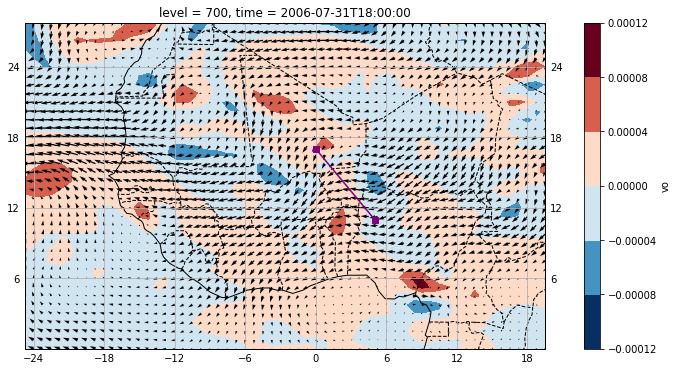

In [4]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(projection=ccrs.PlateCarree())

ds_ = ds_ei.sel(level=700, time='2006-07-31 18:00', longitude=slice(-25, 20), latitude=slice(28, 0))

ds_.vo.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
plt.quiver(*np.meshgrid(ds_.longitude, ds_.latitude, indexing='xy'), ds_.u, ds_.v)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='--')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False

plt.plot([p0[1], p1[1]], [p0[0], p1[0]], linestyle='-', marker='s', color='purple')



## Definining new grid

In [5]:
# define new grid
Nx = 100
Ny = 1
Nz = len(ds_ei.level)
i = range(Nx)
j = range(Ny)
k = range(Nz)
ds_grid = xr.Dataset(coords=dict(i=i, j=j, k=k))

ds_grid['lat'] = (('i', 'j'), np.array([np.linspace(p0[0], p1[0], Nx),]).T)
ds_grid['lon'] = (('i', 'j'), np.array([np.linspace(p0[1], p1[1], Nx),]).T)
ds_grid['level'] = (('k'), ds_ei.level)

ds_grid

<xarray.Dataset>
Dimensions:  (i: 100, j: 1, k: 27)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0
Data variables:
    lat      (i, j) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
    lon      (i, j) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...
    level    (k) int32 100 125 150 175 200 225 250 300 350 400 450 500 550 ...

In [6]:
# create a dataset to hold the original grid information
ds_oldgrid = xr.Dataset()
ds_oldgrid['level'] = ds_ei.level
ds_oldgrid['lat'] = ds_ei.latitude
ds_oldgrid['lon'] = ds_ei.longitude

ds_oldgrid

<xarray.Dataset>
Dimensions:    (latitude: 68, level: 27, longitude: 102)
Coordinates:
  * level      (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
  * latitude   (latitude) float32 45.0 44.25 43.5 42.75 42.0 41.25 40.5 ...
  * longitude  (longitude) float32 -25.5 -24.75 -24.0 -23.25 -22.5 -21.75 ...
Data variables:
    lat        (latitude) float32 45.0 44.25 43.5 42.75 42.0 41.25 40.5 ...
    lon        (longitude) float32 -25.5 -24.75 -24.0 -23.25 -22.5 -21.75 ...

In [7]:
import xesmf

In [8]:
regridder = xesmf.Regridder(ds_in=ds_oldgrid, ds_out=ds_grid, method='bilinear')

Overwrite existing file: bilinear_68x102_100x1.nc 
 You can set reuse_weights=True to save computing time.


In [9]:
ds_ = ds_ei.sel(time="2006-07-31 12:00")
ds_ei_transect = xr.Dataset()
ds_ei_transect['w'] = regridder(ds_.w)
ds_ei_transect['vo'] = regridder(ds_.vo)

ds_ei_transect = ds_ei_transect.squeeze()
ds_ei_transect

<xarray.Dataset>
Dimensions:  (i: 100, level: 27)
Coordinates:
    lon      (i) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 0.3535 ...
    lat      (i) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 16.52 ...
    time     datetime64[ns] 2006-07-31T12:00:00
  * level    (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
Dimensions without coordinates: i
Data variables:
    w        (level, i) float64 0.003443 0.003623 0.003821 0.004038 0.004272 ...
    vo       (level, i) float64 1.147e-05 1.186e-05 1.225e-05 1.263e-05 ...

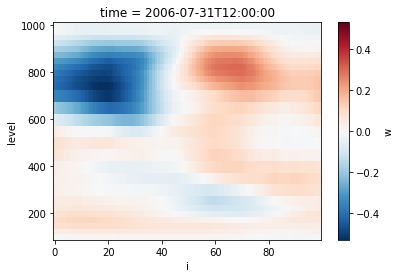

In [10]:
ds_ei_transect.w.plot()

In [11]:
ds_ei_transect['lat'] = (('i',), ds_ei_transect.lat)
ds_ei_transect = ds_ei_transect.swap_dims(dict(i='lat'))
ds_ei_transect

<xarray.Dataset>
Dimensions:  (lat: 100, level: 27)
Coordinates:
    lon      (lat) float64 0.0 0.05051 0.101 0.1515 0.202 0.2525 0.303 ...
  * lat      (lat) float64 17.0 16.94 16.88 16.82 16.76 16.7 16.64 16.58 ...
    time     datetime64[ns] 2006-07-31T12:00:00
  * level    (level) int32 100 125 150 175 200 225 250 300 350 400 450 500 ...
Data variables:
    w        (level, lat) float64 0.003443 0.003623 0.003821 0.004038 ...
    vo       (level, lat) float64 1.147e-05 1.186e-05 1.225e-05 1.263e-05 ...

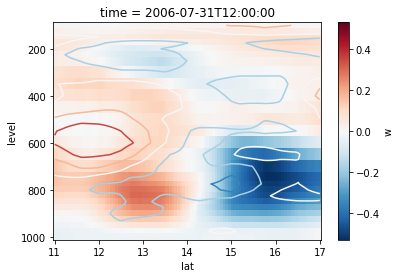

In [12]:
ds_ei_transect.w.plot(yincrease=False)
ds_ei_transect.vo.plot.contour(yincrease=False)

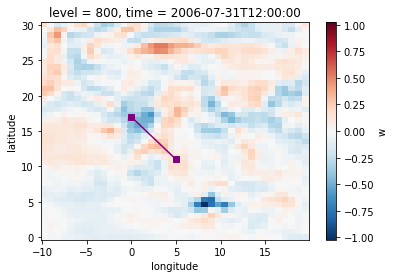

In [13]:
ds_.w.sel(level=800, longitude=slice(-10, 20), latitude=slice(30, 0)).plot()
plt.plot([p0[1], p1[1]], [p0[0], p1[0]], linestyle='-', marker='s', color='purple')